In [2]:
"""
Imports
"""
import sys
print(f"Python:\t{sys.version}")
import numpy as np
print(f"Numpy:\t\t{np.__version__}")
import tensorflow as tf
print(f"Tensorflow:\t{tf.__version__}")
import keras
print(f"Keras:\t\t{keras.__version__}")

import os
import matplotlib.pyplot as plt
from keras import Sequential
from keras import layers
from keras.applications import MobileNet  # https://keras.io/api/applications/mobilenet/#mobilenet-function
from tensorflow.keras.applications.mobilenet import preprocess_input

Python:	3.8.20 (default, Oct  3 2024, 15:19:54) [MSC v.1929 64 bit (AMD64)]
Numpy:		1.23.0
Tensorflow:	2.10.0
Keras:		2.10.0


In [4]:
"""
Options
"""
model_name = "MobileNet_70ftfl_60e_32b"

image_width = 128
image_height = 128
channels_dim = 3
classes_dim = 6
batch_size = 32

validation_split = 0.2
fine_tuning_frozen_layers = 0.7
base_learning_rate = 0.001
epochs_pretraining = 10
epochs_total = 60

shape = (image_height, image_width, channels_dim)

In [5]:
"""
Pathing
"""
SPECTROGRAMS_DIR = "../data/spectrograms/combined"
TF_MODELS_DIR = "../data/models_tf"
TFLITE_MODELS_DIR = "../data/models_tflite"

In [6]:
"""
Configure GPU
"""
gpus = tf.config.list_physical_devices("GPU")
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices("GPU")
    print(f"{len(gpus)} physical GPUs\n{len(logical_gpus)} logical GPUs")
  except RuntimeError as e:
    print(f"Error: {e}")

1 physical GPUs
1 logical GPUs


In [ ]:
"""
Functions
"""
def one_hot_encode(image, label):
    label = tf.one_hot(label, depth=classes_dim)
    return image, label

In [ ]:
"""
Load data
"""
train = tf.keras.utils.image_dataset_from_directory(
    SPECTROGRAMS_DIR,
    validation_split=0.2,
    subset='training',
    image_size=(image_height, image_width),
    batch_size=batch_size,
    seed=123
)
class_names = train.class_names
train = train.map(one_hot_encode)

valid = tf.keras.utils.image_dataset_from_directory(
    SPECTROGRAMS_DIR,
    validation_split=0.2,
    subset='validation',
    image_size=(image_height, image_width),
    batch_size=batch_size,
    seed=123
)
valid = valid.map(one_hot_encode)

In [7]:
"""
Clear session
"""
tf.keras.backend.clear_session()

"""
Preprocessing
"""
model_input = keras.Input(shape=(None, None, 3))
x = model_input
x = layers.Resizing(image_height, image_width)(x)
x = layers.Lambda(preprocess_input)(x)

"""
Build MobileNet model
"""

mobilenet = MobileNet(
    input_shape=shape,
    alpha=1.0,
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax"
)

mobilenet.trainable = False
x = mobilenet(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.25)(x)
mobilenet_output = layers.Dense(classes_dim, activation="softmax")(x)

mobilenet_model = keras.Model(model_input, mobilenet_output)
mobilenet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
mobilenet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 resizing (Resizing)         (None, 128, 128, 3)       0         
                                                                 
 lambda (Lambda)             (None, 128, 128, 3)       0         
                                                                 
 mobilenet_1.00_128 (Functi  (None, 4, 4, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               131200

Epoch 1/10
1030/1030 [==============================] - 404s 388ms/step - loss: 1.3455 - accuracy: 0.4552 - val_loss: 1.2196 - val_accuracy: 0.5132
Epoch 2/10
1030/1030 [==============================] - 397s 385ms/step - loss: 1.1880 - accuracy: 0.5239 - val_loss: 1.1538 - val_accuracy: 0.5394
Epoch 3/10
1030/1030 [==============================] - 400s 388ms/step - loss: 1.1342 - accuracy: 0.5481 - val_loss: 1.1136 - val_accuracy: 0.5598
Epoch 4/10
1030/1030 [==============================] - 397s 385ms/step - loss: 1.0953 - accuracy: 0.5636 - val_loss: 1.0925 - val_accuracy: 0.5659
Epoch 5/10
1030/1030 [==============================] - 388s 376ms/step - loss: 1.0721 - accuracy: 0.5732 - val_loss: 1.0881 - val_accuracy: 0.5712
Epoch 6/10
1030/1030 [==============================] - 407s 395ms/step - loss: 1.0402 - accuracy: 0.5860 - val_loss: 1.0800 - val_accuracy: 0.5756
Epoch 7/10
1030/1030 [==============================] - 399s 387ms/step - loss: 1.0197 - accuracy: 0.5939 - val_

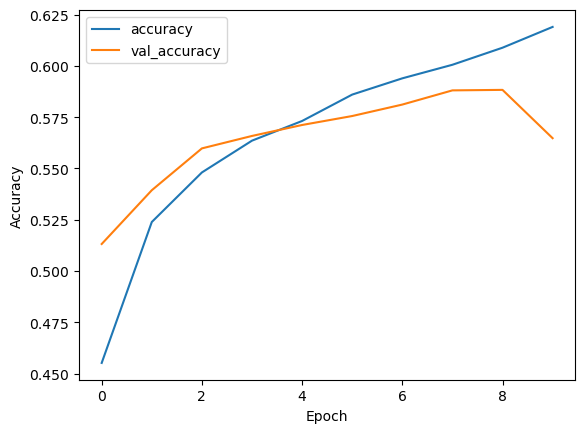

In [8]:
"""
Train model
"""

history_pretraining = mobilenet_model.fit(train, validation_data=valid, epochs=epochs_pretraining)

plt.plot(history_pretraining.history['accuracy'], label='accuracy')
plt.plot(history_pretraining.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 resizing (Resizing)         (None, 128, 128, 3)       0         
                                                                 
 lambda (Lambda)             (None, 128, 128, 3)       0         
                                                                 
 mobilenet_1.00_128 (Functi  (None, 4, 4, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               131200

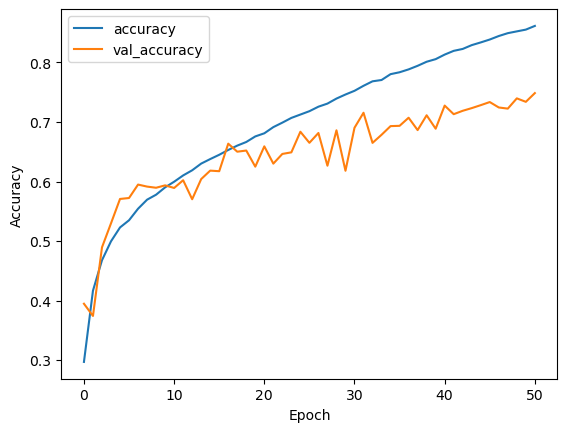

In [9]:
"""
Fine tuning
"""
mobilenet.trainable = True
frozen_layers_amount = int(fine_tuning_frozen_layers * len(mobilenet.layers))
for layer in mobilenet.layers[:frozen_layers_amount]:
  layer.trainable = False
    
mobilenet_model.compile(
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=(base_learning_rate / 10)),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
mobilenet_model.summary()
history_fine_tuning = mobilenet_model.fit(train, validation_data=valid, epochs=epochs_total, initial_epoch=history_pretraining.epoch[-1])

plt.plot(history_fine_tuning.history["accuracy"], label="accuracy")
plt.plot(history_fine_tuning.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [10]:
"""
Save model
"""
mobilenet_model.save(f"{TF_MODELS_DIR}/{model_name}")

INFO:tensorflow:Assets written to: ../data/models_tf/MobileNet_70ftfl_60e_32b\assets


INFO:tensorflow:Assets written to: ../data/models_tf/MobileNet_70ftfl_60e_32b\assets


In [ ]:
"""
Convert SavedModel (TensorFlow) to .tflite
"""
converter = tf.lite.TFLiteConverter.from_saved_model(f"{TF_MODELS_DIR}/{model_name}")
tflite_model = converter.convert()

with open(f"{TFLITE_MODELS_DIR}/{model_name}.tflite", "wb") as f:
  f.write(tflite_model)

In [8]:
"""
Confusion Matrix
"""
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

loaded_model = keras.models.load_model(f"{TF_MODELS_DIR}/{model_name}")

X_val = []
y_val = []

for images, labels in valid:
    X_val.append(images.numpy())
    y_val.append(labels.numpy())
X_val = np.vstack(X_val)
y_val = np.vstack(y_val)

y_true = np.argmax(y_val, axis=1)
y_pred_probs = loaded_model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix - Validation Set")
plt.show()

C:\CodingPrograms\miniconda3\envs\gpu\lib\site-packages\keras\layers\core\lambda_layer.py:327: UserWarning: keras.src.applications.mobilenet is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\CodingPrograms\miniconda3\envs\gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\dgajd\AppData\Local\Temp\ipykernel_14316\3783592926.py", line 7, in <module>
    loaded_model = keras.models.load_model(f"{TF_MODELS_DIR}/{model_name}")
  File "C:\CodingPrograms\miniconda3\envs\gpu\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:/Users/dgajd/AppData/Roaming/Python/Python38/site-packages/keras/src/applications/mobilenet.py", line 474, in preprocess_input
NameError: Exception encountered when calling layer "lambda" (type Lambda).

name 'imagenet_utils' is not defined

Call arguments received by layer "lambda" (type Lambda):
  • inputs=tf.Tensor(shape=(None, 128, 128, 3), dtype=float32)
  • mask=None
  • training=False

During handling of the above exception, 